In [27]:
import pandas as pd
import numpy as np
import random
import datetime
import uuid
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly as px

In [3]:
import pandas as pd
import numpy as np
import random
import datetime
import uuid

def generate_sales_data(n=2000000):
    """
    Generates a Pandas DataFrame with n rows of sales data,
    including intentional errors for data cleaning practice.
    """
    print(f"Generating {n} rows of data...")

    # --- 1. Generate Core Data (Vectorized for Speed) ---
    
    # Order IDs: UUIDs
    print("Generating UUIDs...")
    order_ids = [str(uuid.uuid4()) for _ in range(n)]
    
    # Dates: Random datetime objects within last 2 years
    print("Generating Dates...")
    base_date = datetime.datetime.now()
    # Generate random seconds offset for 2 years (approx)
    seconds_offset = np.random.randint(0, 63072000, n)
    order_dates = [base_date - datetime.timedelta(seconds=int(x)) for x in seconds_offset]
    
    # --- Customer Generation (Consistent Profiles) ---
    print("Generating Customers...")
    # Customers (Simulate fewer unique customers than orders)
    num_customers = n // 5  # e.g., 400k unique customers implies avg 5 orders per customer
    unique_customer_ids = np.arange(1000, 1000 + num_customers)
    
    # Realistic LatAm Names Components
    first_names = ["Juan", "María", "Pedro", "Ana", "Luis", "Carmen", "Carlos", "Josefa", "Jorge", "Isabel", 
                   "Miguel", "Paula", "Francisco", "Elena", "Antonio", "Luisa", "David", "Raquel", "Javier", "Lucía",
                   "Sofía", "Mateo", "Valentina", "Santiago", "Camila", "Sebastián", "Isabella", "Benjamín", "Felipe", "Mariana"]
    last_names = ["González", "Rodríguez", "Pérez", "Fernández", "López", "García", "Martínez", "Sánchez", 
                  "Romero", "Díaz", "Muñoz", "Rojas", "Silva", "Torres", "Vargas", "Ramírez", "Flores", "Acosta",
                  "Gomez", "Morales", "Rivera", "Castillo", "Ortiz", "Gutierrez", "Chavez", "Castro", "Ruiz"]

    # Allowed Countries with Population-based Weights (Approx)
    countries = ["Brasil", "México", "Colombia", "Argentina", "Perú", "Chile", "Ecuador", "Uruguay"]
    # Approx weights based on population (very rough relative scale)
    country_weights = [0.40, 0.25, 0.10, 0.09, 0.07, 0.04, 0.03, 0.02]
    
    # Generate profiles for unique customers
    # We use numpy for fast random choice
    u_firsts = np.random.choice(first_names, num_customers)
    u_lasts = np.random.choice(last_names, num_customers)
    u_countries = np.random.choice(countries, num_customers, p=country_weights)
    
    # Create a mapping DataFrame for customers
    df_customers = pd.DataFrame({
        "customer_id": unique_customer_ids,
        "customer_first": u_firsts,
        "customer_last": u_lasts,
        "customer_country": u_countries
    })

    # Country Code Mapping
    country_code_map = {
        "Brasil": "BRA", "México": "MEX", "Colombia": "COL", "Argentina": "ARG", 
        "Perú": "PER", "Chile": "CHL", "Ecuador": "ECU", "Uruguay": "URY"
    }
    df_customers["country_code"] = df_customers["customer_country"].map(country_code_map)
    
    df_customers["customer_name"] = df_customers["customer_first"] + " " + df_customers["customer_last"]
    
    # Vectorized email generation
    df_customers["customer_email"] = (
        df_customers["customer_first"].str.lower() + "." + 
        df_customers["customer_last"].str.lower() + 
        "_" + df_customers["customer_id"].astype(str) + 
        "@example.com"
    )

    # City generation 
    city_map = {
        "Chile": ["Santiago", "Valparaíso", "Concepción", "La Serena", "Antofagasta", "Temuco", "Rancagua"],
        "Argentina": ["Buenos Aires", "Córdoba", "Rosario", "Mendoza", "La Plata", "Tucumán", "Mar del Plata"],
        "Uruguay": ["Montevideo", "Salto", "Ciudad de la Costa", "Paysandú", "Maldonado"],
        "Perú": ["Lima", "Arequipa", "Trujillo", "Chiclayo", "Cusco", "Piura", "Iquitos"],
        "Colombia": ["Bogotá", "Medellín", "Cali", "Barranquilla", "Cartagena", "Cúcuta", "Bucaramanga"],
        "Brasil": ["São Paulo", "Rio de Janeiro", "Brasília", "Salvador", "Fortaleza", "Belo Horizonte", "Manaus"],
        "Ecuador": ["Guayaquil", "Quito", "Cuenca", "Santo Domingo", "Ambato"],
        "México": ["Ciudad de México", "Guadalajara", "Monterrey", "Puebla", "Tijuana", "León", "Juárez"]
    }
    
    # Assign a random city from the country for each customer
    def get_city(country):
        return np.random.choice(city_map.get(country, ["Unknown"]))
    
    print("Mapping cities to customers...")
    df_customers["customer_city"] = df_customers["customer_country"].apply(get_city)
    
    # Address - randomized
    df_customers["customer_address"] = [f"{random.randint(1,9999)} Calle {random.choice(['Principal', 'Secundaria', 'Norte', 'Sur', 'Este', 'Oeste', 'Los Alamos', 'Los Pinos'])}" for _ in range(num_customers)]

    # Distribute customers to orders
    print("Assigning orders to customers...")
    chosen_customer_ids = np.random.choice(unique_customer_ids, n)
    
    # Map customers to countries for the orders
    customer_country_map = df_customers.set_index("customer_id")["customer_country"]
    # Efficiently map: lookups random array using pandas index
    # We might need to ensure chosen_customer_ids are series/array to map
    order_countries = customer_country_map.loc[chosen_customer_ids].values
    
    # --- Products Generation (Stratified by Country) ---
    # Enhanced product list with realistic prices and weights
    products = [
        {"id": "P001", "name": "Laptop Pro", "cat": "Electronics", "price": 1200.00, "weight": 2.5},
        {"id": "P002", "name": "Smartphone X", "cat": "Electronics", "price": 800.00, "weight": 0.2},
        {"id": "P003", "name": "Wireless Mouse", "cat": "Accessories", "price": 25.50, "weight": 0.1},
        {"id": "P004", "name": "Mechanical Keyboard", "cat": "Accessories", "price": 150.00, "weight": 1.2},
        {"id": "P005", "name": "Monitor 27in", "cat": "Electronics", "price": 300.00, "weight": 5.0},
        {"id": "P006", "name": "Coffee Maker", "cat": "Home", "price": 85.00, "weight": 3.0},
        {"id": "P007", "name": "Blender", "cat": "Home", "price": 45.00, "weight": 2.2},
        {"id": "P008", "name": "Office Chair", "cat": "Furniture", "price": 200.00, "weight": 15.0},
        {"id": "P009", "name": "Running Shoes", "cat": "Fashion", "price": 120.00, "weight": 0.8},
        {"id": "P010", "name": "T-Shirt", "cat": "Fashion", "price": 20.00, "weight": 0.2},
        {"id": "P011", "name": "Smart TV 55in", "cat": "Electronics", "price": 600.00, "weight": 12.0},
        {"id": "P012", "name": "Headphones NoiseCancelling", "cat": "Electronics", "price": 250.00, "weight": 0.3},
        {"id": "P013", "name": "Gaming Console", "cat": "Electronics", "price": 500.00, "weight": 3.5},
        {"id": "P014", "name": "Microwave Oven", "cat": "Home", "price": 150.00, "weight": 10.0},
        {"id": "P015", "name": "Hair Dryer", "cat": "Home", "price": 35.00, "weight": 0.6},
        {"id": "P016", "name": "Sofa 3-Seater", "cat": "Furniture", "price": 800.00, "weight": 45.0},
        {"id": "P017", "name": "Bookshelf", "cat": "Furniture", "price": 120.00, "weight": 18.0},
        {"id": "P018", "name": "Jeans", "cat": "Fashion", "price": 45.00, "weight": 0.5},
        {"id": "P019", "name": "Sneakers", "cat": "Fashion", "price": 85.00, "weight": 0.7},
        {"id": "P020", "name": "Backpack", "cat": "Accessories", "price": 55.00, "weight": 0.4},
    ]
    
    # Define Weights Profiles
    # Profile 1: Tech Enthusiasts (Chile, Uruguay)
    weights_tech = np.array([0.15, 0.15, 0.05, 0.08, 0.10, 0.02, 0.02, 0.05, 0.05, 0.02, 0.10, 0.08, 0.10, 0.01, 0.01, 0.005, 0.005, 0.0, 0.0, 0.0])
    weights_tech /= weights_tech.sum()

    # Profile 2: Fashion/Home (Argentina, Colombia, Peru)
    weights_home = np.array([0.02, 0.05, 0.02, 0.01, 0.02, 0.10, 0.10, 0.05, 0.10, 0.15, 0.05, 0.02, 0.03, 0.08, 0.08, 0.02, 0.02, 0.05, 0.03, 0.0])
    weights_home /= weights_home.sum()

    # Profile 3: Balanced/General (Brasil, Mexico, Ecuador)
    weights_balanced = np.ones(len(products)) / len(products)
    
    print("Generating Products (Weighted by Country)...")
    
    # Pre-allocate arrays
    prod_choices = np.empty(n, dtype=object)
    
    # Vectorized application of weights
    # We'll split indices by country group to apply random choice efficiently
    
    # Group Countries
    countries_tech = ["Chile", "Uruguay"]
    countries_home = ["Argentina", "Colombia", "Perú"]
    countries_balanced = ["Brasil", "México", "Ecuador"]
    
    # Masks
    mask_tech = np.isin(order_countries, countries_tech)
    mask_home = np.isin(order_countries, countries_home)
    mask_balanced = np.isin(order_countries, countries_balanced)
    
    # Generate for Tech group
    if np.any(mask_tech):
        n_tech = np.sum(mask_tech)
        prod_choices[mask_tech] = np.random.choice(products, n_tech, p=weights_tech)
        
    # Generate for Home group
    if np.any(mask_home):
        n_home = np.sum(mask_home)
        prod_choices[mask_home] = np.random.choice(products, n_home, p=weights_home)
        
    # Generate for Balanced group
    if np.any(mask_balanced):
        n_bal = np.sum(mask_balanced)
        prod_choices[mask_balanced] = np.random.choice(products, n_bal, p=weights_balanced)
    
    # Use fallback for any missing holes (shouldn't be any, but good practice)
    mask_filled = mask_tech | mask_home | mask_balanced
    if not np.all(mask_filled):
        n_miss = n - np.sum(mask_filled)
        prod_choices[~mask_filled] = np.random.choice(products, n_miss) # Uniform fallback

    # Extract details
    prod_ids = [p["id"] for p in prod_choices]
    prod_names = [p["name"] for p in prod_choices]
    prod_cats = [p["cat"] for p in prod_choices]
    prod_prices = np.array([p["price"] for p in prod_choices])
    prod_weights = np.array([p["weight"] for p in prod_choices])
    
    # Quantities - Vary slightly by profile too? Let's keep quantities simple but maybe higher for 'Home' items?
    # Keeping quantities random for now to avoid over-complicating.
    quantities = np.random.choice([1, 2, 3, 4, 5, 10], n, p=[0.7, 0.15, 0.1, 0.03, 0.01, 0.01])
    
    # --- New Numeric Variables ---
    print("Calculating financials...")
    # Base Amount
    total_amounts = quantities * prod_prices
    
    # Discount (0%, 5%, 10%, 20%)
    discounts_rates = np.random.choice([0.0, 0.05, 0.10, 0.20], n, p=[0.6, 0.2, 0.15, 0.05])
    discount_amounts = total_amounts * discounts_rates
    
    # Tax (Standard 19% approx for LatAm avg, simplified)
    tax_rate = 0.19
    tax_amounts = (total_amounts - discount_amounts) * tax_rate
    
    # Shipping Cost based on weight
    # Base rate + weight factor
    # Simplify: 5.00 base + 1.50 per kg
    total_weights = quantities * prod_weights
    shipping_costs = 5.00 + (total_weights * 1.50)
    
    # Final Total
    final_totals = (total_amounts - discount_amounts) + tax_amounts + shipping_costs
    
    
    # Additional Columns with Heterogeneous Distribution
    # Rule 1: High Amount (> $1000) -> Mostly Credit Card
    # Rule 2: Brazil -> High Credit Card preference
    # Rule 3: Low Amount (< $50) -> Cash/Debit/PayPal
    
    print("Generating Payment Methods (Correlated)...")
    payment_methods = np.empty(n, dtype=object)
    
    pm_opts = ["Credit Card", "Debit Card", "PayPal", "Bank Transfer"]
    
    # Probability Matrices for vectorized choice
    # We will loop through chunks or valid masks again
    
    # Mask 1: High Value
    mask_high_val = final_totals > 1000
    # Mask 2: Low Value
    mask_low_val = final_totals < 50
    # Mask 3: Brazil (High Credit Use)
    mask_brazil = order_countries == "Brasil"
    # Mask 4: Argentina (Debit/Cash heavy in this simulation)
    mask_arg = order_countries == "Argentina"
    
    # Default selection (Mid range, other countries)
    # Weights: CC 40%, DC 40%, PP 15%, BT 5%
    default_probs = [0.40, 0.40, 0.15, 0.05]
    
    # Logic Application loop (a bit manual but clear)
    # We iterate and assign based on hierarchy or just apply broadly
    
    # Let's generate a base for everyone first
    payment_methods[:] = np.random.choice(pm_opts, n, p=default_probs)
    
    # Apply Overrides
    
    # Brazil Override: CC 70%, DC 20%, PP 5%, BT 5%
    n_br = np.sum(mask_brazil)
    if n_br > 0:
        payment_methods[mask_brazil] = np.random.choice(pm_opts, n_br, p=[0.70, 0.20, 0.05, 0.05])
        
    # Argentina Override: CC 30%, DC 50%, PP 10%, BT 10%
    n_arg = np.sum(mask_arg)
    if n_arg > 0:
        payment_methods[mask_arg] = np.random.choice(pm_opts, n_arg, p=[0.30, 0.50, 0.10, 0.10])
        
    # High Value Override (Global, stronger than country? Maybe)
    # If > 1000, force shifting towards Credit Card/Transfer
    # CC 80%, BT 15%, DC 5%, PP 0%
    n_high = np.sum(mask_high_val)
    if n_high > 0:
        payment_methods[mask_high_val] = np.random.choice(pm_opts, n_high, p=[0.80, 0.05, 0.0, 0.15])
        
    # Low Value Override
    # CC 10%, DC 60%, PP 30%, BT 0%
    n_low = np.sum(mask_low_val)
    if n_low > 0:
        payment_methods[mask_low_val] = np.random.choice(pm_opts, n_low, p=[0.10, 0.60, 0.30, 0.0])

    shipping_statuses = np.random.choice(["Shipped", "Processing", "Delivered", "Cancelled"], n)
    
    # --- 2. Create DataFrame ---
    print("Assembling DataFrame...")
    
    # Create the orders DataFrame
    df_orders = pd.DataFrame({
        "order_id": order_ids,
        "order_date": order_dates,
        "customer_id": chosen_customer_ids,
        "product_id": prod_ids,
        "product_name": prod_names,
        "product_category": prod_cats,
        "quantity": quantities,
        "price_per_unit": prod_prices,
        "total_amount_gross": total_amounts,
        "discount_amount": discount_amounts,
        "tax_amount": tax_amounts,
        "shipping_cost": shipping_costs,
        "final_total_amount": final_totals,
        "payment_method": payment_methods,
        "shipping_status": shipping_statuses,
        "total_weight": total_weights
    })
    
    # Merge with customers to get customer details
    # This ensures consistency: same customer_id always has same name/email/country/city
    print("Merging with Customer Data...")
    df = pd.merge(df_orders, df_customers, on="customer_id", how="left")
    
    # Reorder columns for readability
    cols = [
        "order_id", "order_date", 
        "customer_id", "customer_name", "customer_email", "customer_country", "country_code", "customer_city", "customer_address",
        "product_id", "product_name", "product_category", "quantity",
        "price_per_unit", "total_weight", "shipping_cost",
        "total_amount_gross", "discount_amount", "tax_amount", "final_total_amount",
        "payment_method", "shipping_status"
    ]
    df = df[cols]
    
    # --- 3. Inject Errors (Dirty Data) ---
    print("Injecting dirty data...")
    
    # 3.1 Null Values - Categorical/String
    df.loc[df.sample(frac=0.05).index, "customer_email"] = np.nan
    df.loc[df.sample(frac=0.10).index, "shipping_status"] = np.nan
    df.loc[df.sample(frac=0.02).index, "customer_city"] = np.nan

    # 3.2 Null Values - Numeric (Requested)
    # Injecting NaNs into numeric columns for pedagogical variety
    print("Injecting numeric nulls...")
    # 1% nulls in tax_amount
    df.loc[df.sample(frac=0.01).index, "tax_amount"] = np.nan
    # 0.5% nulls in shipping_cost
    df.loc[df.sample(frac=0.005).index, "shipping_cost"] = np.nan
    # 0.1% nulls in total_weight
    df.loc[df.sample(frac=0.001).index, "total_weight"] = np.nan
    # 0.2% nulls in price_per_unit (critical error)
    df.loc[df.sample(frac=0.002).index, "price_per_unit"] = np.nan

    # 3.3 Logic Errors
    # Negative quantities (0.1% of data)
    err_idx_neg = df.sample(frac=0.001).index
    df.loc[err_idx_neg, "quantity"] = df.loc[err_idx_neg, "quantity"] * -1
    
    # Total amount mismatch (0.5% of data) -> Price check fail
    err_idx_math = df.sample(frac=0.005).index
    df.loc[err_idx_math, "final_total_amount"] = df.loc[err_idx_math, "final_total_amount"] * 0.5

    # 3.4 String Format Issues
    # Payment Method casing
    df["payment_method"] = df["payment_method"].apply(lambda x: x.lower() if random.random() < 0.1 else x.upper() if random.random() < 0.1 else x)
    
    # Whitespace in Product Name
    df["product_name"] = df["product_name"].apply(lambda x: f" {x} " if random.random() < 0.05 else x)

    # 3.5 Inconsistent Types (Dates)
    # Dirty dates: Convert some to invalid string formats
    # First convert all to generic object/string to allow mixed types
    # df["order_date"] is currently datetime64 (or object of datetimes).
    
    # To mix types in pandas, we usually need 'object' dtype
    df["order_date"] = df["order_date"].astype(object)
    
    err_idx_date = df.sample(frac=0.01).index
    # Assign invalid date strings
    df.loc[err_idx_date, "order_date"] = "2024-13-01" 
    
    # 3.6 Duplicates
    duplicates = df.sample(n=1000)
    df = pd.concat([df, duplicates], ignore_index=True)
    
    print(f"Dataset generated with shape: {df.shape}")
    return df

if __name__ == "__main__":
    # Generate the data
    df_sales = generate_sales_data(2000000)
    
    # Save to CSV
    output_file = "sales_data_dirty.csv"
    print(f"Saving to {output_file}...")
    df_sales.to_csv(output_file, index=False)
    print("Done!")

Generating 2000000 rows of data...
Generating UUIDs...
Generating Dates...
Generating Customers...
Mapping cities to customers...
Assigning orders to customers...
Generating Products (Weighted by Country)...
Calculating financials...
Generating Payment Methods (Correlated)...
Assembling DataFrame...
Merging with Customer Data...
Injecting dirty data...
Injecting numeric nulls...
Dataset generated with shape: (2001000, 22)
Saving to sales_data_dirty.csv...
Done!


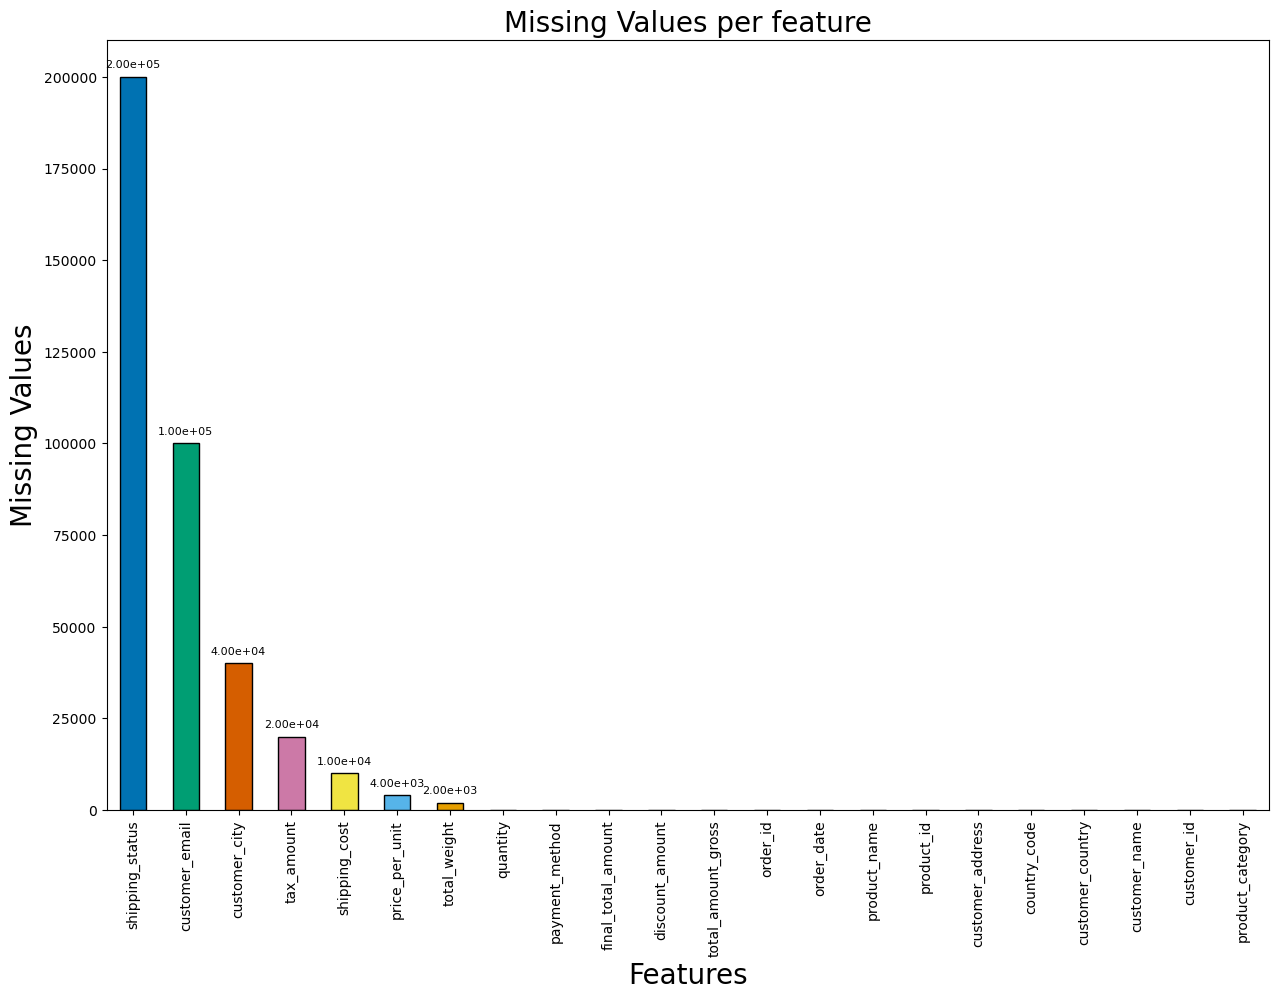

In [4]:
colores_hex = [
    '#0072B2', # Azul
    '#009E73', # Verde Esmeralda
    '#D55E00', # Bermellón
    '#CC79A7', # Púrpura Rojizo
    '#F0E442', # Amarillo
    '#56B4E9', # Azul Cielo
    '#E69F00', # Naranja
    '#999999'  # Gris
]
ax = df_sales.isna().sum().sort_values(ascending=False).plot(kind = 'bar',color = colores_hex ,figsize=(15,10), edgecolor = 'black') 
plt.title("Missing Values per feature",fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Missing Values", fontsize=20) 
conteo = df_sales.isna().sum().sort_values(ascending=False)
labels = [f'{val:.2e}' if val > 0 else '' for val in conteo]

# 3. Aplicamos las etiquetas personalizadas
ax.bar_label(ax.containers[0], labels=labels, padding=5, fontsize=8)
plt.show() 

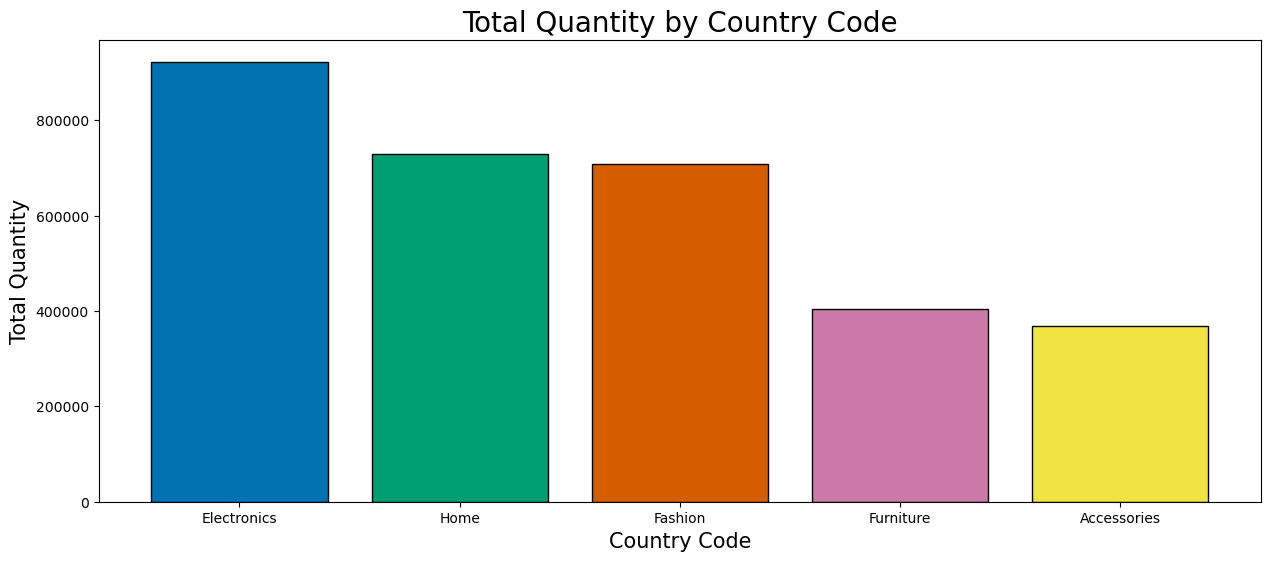

In [5]:
df_grouped = df_sales.groupby('product_category')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

colores_hex = [
    '#0072B2', # Azul
    '#009E73', # Verde Esmeralda
    '#D55E00', # Bermellón
    '#CC79A7', # Púrpura Rojizo
    '#F0E442', # Amarillo
    '#56B4E9', # Azul Cielo
    '#E69F00', # Naranja
    '#999999'  # Gris
]

plt.figure(figsize=(15, 6))
plt.bar(df_grouped['product_category'], df_grouped['quantity'], color=colores_hex, edgecolor='black')
plt.xlabel('Country Code', fontsize = 15)
plt.ylabel('Total Quantity', fontsize = 15)
plt.title('Total Quantity by Country Code', fontsize = 20)

plt.show()

In [6]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [7]:
agg_dict = {'customer_id':['count','nunique'],'order_id':['nunique'],'product_id':'count', 'total_amount_gross':['sum','mean']}

df_sales['payment_method'] = df_sales['payment_method'].str.title().str.strip()

df_agrupado = df_sales.groupby(['payment_method','country_code'])[['customer_id','order_id','product_id','total_amount_gross']].agg(agg_dict).round(2)
df_agrupado.sort_values(by=('customer_id','count'), ascending=False).reset_index()


payment_method country_code customer_id         order_id product_id  \
                                     count nunique  nunique      count   
0     Credit Card          BRA      520263  153620   520011     520263   
1     Credit Card          MEX      212411   88141   212297     212411   
2      Debit Card          MEX      184504   84215   184402     184504   
3      Debit Card          BRA      177544  107174   177459     177544   
4      Debit Card          ARG       86125   32677    86089      86125   
5      Debit Card          COL       81906   34770    81872      81906   
6     Credit Card          COL       75851   33931    75817      75851   
7          Paypal          MEX       72409   51422    72367      72409   
8      Debit Card          PER       56815   24250    56784      56815   
9          Paypal          BRA       55780   47114    55755      55780   
10    Credit Card          ARG       54853   28113    54823      54853   
11    Credit Card          PER       52766   23709    52743      52766   
12  Bank Transfer          BRA       46797   40656    46772      46797   
13    Credit Card          CHL       39956   14802    39944      39956   
14         Paypal          COL       33058   22495    33038      33058   
15  Bank Transfer          MEX       29748   25749    29729      29748   
16    Credit Card          ECU       25683   10722    25676      25683   
17     Debit Card          CHL       25270   12707    25258      25270   
18         Paypal          ARG       23133   17053    23118      23133   
19         Paypal          PER       22830   15595    22817      22830   
20     Debit Card          ECU       22442   10167    22430      22442   
21    Credit Card          URY       20233    7490    20222      20233   
22  Bank Transfer          ARG       15463   12599    15456      15463   
23     Debit Card          URY       12938    6485    12929      12938   
24  Bank Transfer          COL        9771    8649     9769       9771   
25         Paypal          CHL        9380    7120     9376       9380   
26         Paypal          ECU        8700    6188     8690       8700   
27  Bank Transfer          PER        6932    6132     6927       6932   
28  Bank Transfer          CHL        6077    5062     6074       6077   
29         Paypal          URY        4695    3568     4692       4695   
30  Bank Transfer          ECU        3600    3108     3599       3600   
31  Bank Transfer          URY        3067    2558     3065       3067   

   total_amount_gross           
                  sum     mean  
0         264204275.0   507.83  
1         135350349.5   637.21  
2          45006576.5   243.93  
3          41852387.0   235.73  
4          16496598.0   191.54  
5          15085163.0   184.18  
6          35867187.0   472.86  
7          14737489.5   203.53  
8          10486547.0   184.57  
9           8339665.0   149.51  
10         29344849.0   534.97  
11         25058697.0   474.90  
12         36990948.5   790.46  
13         41528012.0  1039.34  
14          5182381.5   156.77  
15         23401723.0   786.67  
16         16256442.5   632.97  
17         10717651.0   424.13  
18          3238339.5   139.99  
19          3565399.5   156.17  
20          5502802.5   245.20  
21         21247608.0  1050.15  
22          6726984.5   435.04  
23          5518346.5   426.52  
24          5942277.0   608.15  
25          3288021.5   350.54  
26          1755884.5   201.83  
27          4149776.5   598.64  
28          7101732.5  1168.62  
29          1646930.0   350.78  
30          2768780.0   769.11  
31          3664011.0  1194.66

In [8]:
print((100*df_sales['shipping_status'].value_counts(normalize = True)).round(3))

shipping_status
Processing    25.024
Cancelled     24.999
Shipped       24.989
Delivered     24.989
Name: proportion, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_3432\2237363092.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_sales['payment_method'], y =df_sales['total_amount_gross'], data = df_sales, palette = 'viridis')


<Axes: xlabel='payment_method', ylabel='total_amount_gross'>

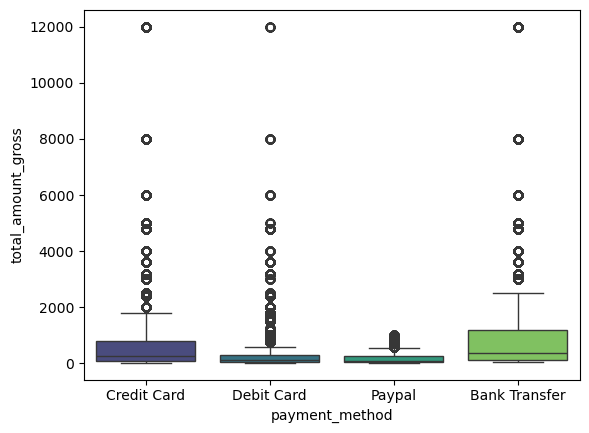

In [9]:
sns.boxplot(x=df_sales['payment_method'], y =df_sales['total_amount_gross'], data = df_sales, palette = 'viridis') 

In [10]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [11]:
dimensiones = ['country_code','product_category']
metricas    = ['total_amount_gross', 'shipping_cost','discount_amount']
agg_dic     = {'total_amount_gross': ['sum','max','min','mean'],
               'shipping_cost'     : ['sum','max','min','mean'],
               'discount_amount'   : ['sum','max','min','mean']}

df_grouped = df_sales.groupby(dimensiones)[metricas].agg(agg_dic).sort_values(by = ('total_amount_gross','sum'), ascending = False)
df_grouped.reset_index().to_excel('Grouped_sales_data.xlsx', index = True)

In [26]:
diccionario = {"nombre": "Juan", "edad": 30, "ciudad": "Madrid"}

x = (2,4)
x[1]

4